---
### Data Set Information:

The goal of the research is to help the auditors by building a classification model that can predict the fraudulent firm on the basis the present and historical risk factors. The information about the sectors and the counts of firms are listed respectively as Irrigation (114), Public Health (77), Buildings and Roads (82), Forest (70), Corporate (47), Animal Husbandry (95), Communication (1), Electrical (4), Land (5), Science and Technology (3), Tourism (1), Fisheries (41), Industries (37), Agriculture (200).

Consider ``Audit_Risk`` as target columns for regression tasks.
### Attribute Information:
Many risk factors are examined from various areas like past records of audit office, audit-paras, environmental conditions reports, firm reputation summary, on-going issues report, profit-value records, loss-value records, follow-up reports etc. After in-depth interview with the auditors, important risk factors are evaluated and their probability of existence is calculated from the present and past records.


### Relevant Papers:
Hooda, Nishtha, Seema Bawa, and Prashant Singh Rana. 'Fraudulent Firm Classification: A Case Study of an External Audit.' Applied Artificial Intelligence 32.1 (2018): 48-64.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns

In [2]:
# Import files
ar = pd.read_csv('../audit_risk.csv')
tr = pd.read_csv('../trial.csv')
print(ar.shape)
print(tr.shape)

(776, 27)
(776, 18)


In [3]:
# comapre column names 
ar_cols = ar.columns
tr_cols = tr.columns

common_cols = ar_cols.intersection(tr_cols)
ar_not_tr = ar_cols.difference(tr_cols)
tr_not_ar = tr_cols.difference(ar_cols)

In [4]:
# Modify common column names and compare their values
# Risk has different values in ar and tr, rest of the common columns have the same values
# Combine two datasets into one (Keep only one copy of the common columns)

tr.rename(columns={'Risk':'tRisk'}, inplace=True) # replace Risk in tr with tRisk 

ar_cols = ar.columns
tr_cols = tr.columns
tr_not_ar = tr_cols.difference(ar_cols)

df = pd.concat([ar,tr[tr_not_ar]], axis=1)
df.shape

(776, 36)

In [5]:
df.isnull().values.sum()

1

In [6]:
# Money_value and aMoney_value have Nan
df[df.isnull().any(1)]

,Sector_score,LOCATION_ID,PARA_A,Score_A,Risk_A,PARA_B,Score_B,Risk_B,TOTAL,numbers,...,Risk,District,History_score,LOSS_SCORE,Loss,MONEY_Marks,Marks,SCORE_A,SCORE_B,tRisk
642,55.57,4,0.23,0.2,0.046,0.0,0.2,0.0,0.23,5.0,...,0,2,2,2,0,2,2,2,2,0


In [8]:
# Fill NAN with mean

print('Money_Value with NaN:',df.loc[:,'Money_Value'].sum())

df['Money_Value'] = df['Money_Value'].fillna(df['Money_Value'].mean())

print('Repalce NaN with mean:',df.loc[:,'Money_Value'].sum())


Money_Value with NaN: 10970.80163096774
Repalce NaN with mean: 10970.80163096774


In [9]:
# Select columns based on their types
flo_vars = list(df.select_dtypes(include=[np.float64]))
int_vars = list(df.select_dtypes(include=[np.int64]))

In [10]:
# Select columns with less than 2 unique values :Detection_Risk'
less2 =[]
for flo in flo_vars:
    a = len(np.unique(df[flo]))
    if a < 2:
        print(flo,', unique values:', a)
        less2.append(flo)
print(less2)        

Detection_Risk , unique values: 1
['Detection_Risk']


In [11]:
# Select columns with less than 2 unique values : Not found
les2 =[]
for it in int_vars:
    a = len(np.unique(df[it]))
    if a < 2:
        print(it,', unique values:', a)
        less2.append(it)
print(les2)

[]


In [12]:
# drop "Detection_Risk"
df = df.drop(['Detection_Risk'], axis=1)

In [ ]:
# Check the patterns for columns with similar names
# Using seaborn pairplot to see the bivariate relation between each pair of features
import seaborn as sns
sns.set()

similar_vars = ['Score_A', 'Score_B', 'Score_B.1', 'SCORE_A', 'SCORE_B']

sns.pairplot(df[similar_vars],size = 1 ,kind ='scatter')
plt.show()

In [13]:
# 10x Score_A = SCORE_A , 10x Score_B = SCORE_B

df = df.drop(['Score_A','Score_B'], axis=1)

In [14]:
# Reorganize column types
dfnames = list(df)

new_flo = list(df.select_dtypes(include=[np.float64]))
new_int = list(df.select_dtypes(include=[np.int64]))

print(len(new_flo),len(new_int))


20 12


In [ ]:
# Using seaborn pairplot to see the bivariate relation between each pair of features
import seaborn as sns
sns.set()

sns.pairplot(df[new_int],size = 1 ,kind ='scatter')
plt.show()

In [15]:
# District  = District_Loss 

df = df.drop(['District'], axis=1)

In [ ]:
# Using seaborn pairplot to see the bivariate relation between each pair of features
import seaborn as sns
sns.set()

sns.pairplot(df[new_flo],size = 1 ,kind ='scatter')
plt.show()

In [16]:
df[['PARA_B','Risk_B']].tail(10)

,PARA_B,Risk_B
766,0.57,0.114
767,0.54,0.108
768,0.53,0.106
769,0.50,0.100
770,0.45,0.090
771,0.40,0.080
772,0.37,0.074
773,0.04,0.008
774,0.00,0.000
775,0.00,0.000


In [17]:
#  2x Money_Value = Risk_D, PARA_A = 50x Risk_A,PARA_B = 50x Risk_B

df = df.drop(['Risk_D','Risk_B','Risk_A'], axis=1)

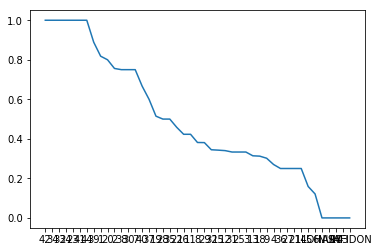

In [18]:
a=df[["LOCATION_ID","Risk"]].groupby("LOCATION_ID").mean().sort_values(by="Risk", ascending=False)

# Risk varies in some LOCATION_IDs
# Need transform location_id

plt.plot(a.index,a['Risk'])
plt.show()

In [19]:
# Rename Location_ID (character to number)
a =[]
for i in df.LOCATION_ID:
    if i == 'SAFIDON':
        new_val = 101
    elif i == 'NUH':
        new_val = 102
    elif i == 'LOHARU':
        new_val = 1003
    else:
        new_val = int(i)
    a.append(new_val)
    #df.LOCATION_ID.replace(i,new_val)
df.LOCATION_ID = a

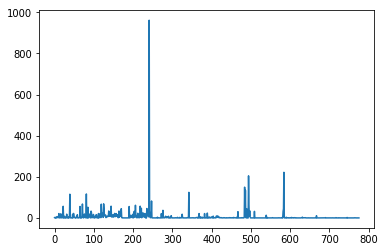

In [20]:
import matplotlib.pyplot as plt

#%matplotlib inline

plt.plot(df['Audit_Risk'])



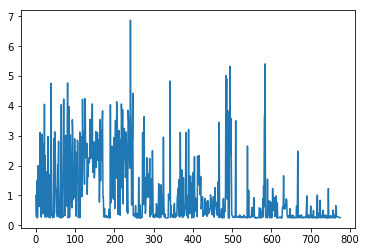

In [21]:
import matplotlib.pyplot as plt

#%matplotlib inline
log_AR = np.log1p(df['Audit_Risk'])

plt.plot(log_AR)

In [22]:
# define independent and dependent variables
# rescale Audit_Risk
# split data

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

X = df.drop(['Audit_Risk'], axis = 1)
y = df['Audit_Risk']

X_train_mm, X_test_mm, y_train, y_test = train_test_split(X, y, random_state =15678 , test_size = 0.15)

scaler  = StandardScaler()
X_train = scaler.fit_transform(X_train_mm)
X_test  = scaler.transform(X_test_mm)
y_train = np.log1p(y_train)
y_test  = np.log1p(y_test)

# inverse of log1p
real_ytest=np.expm1(y_test)

### Gradient Boosting (Decision Tree)

In [23]:
from  sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Decision Tree parameters are adapted from previou result  

grid_values = {'max_depth'  : [ 5, 10, 20, 50],
              'n_estimators': [ 10, 50, 100, 200, 500],
              'learning_rate': [ 0.1, 0.2, 0.5, 0.8]}


gbrt = GradientBoostingRegressor(random_state=42)

grid_clf = GridSearchCV(gbrt, cv = 5, param_grid = grid_values)

grid_clf.fit(X_train, y_train)

print('Grid best parameter (max. accuracy): ', grid_clf.best_params_)
print('Grid best score (accuracy): ', grid_clf.best_score_)

Grid best parameter (max. accuracy):  {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
Grid best score (accuracy):  0.983848695455148


In [24]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Apply best parameters

gbrt = GradientBoostingRegressor(**grid_clf.best_params_, random_state=42)
gbrt.fit(X_train, y_train)

lm_dummy_mean = DummyRegressor(strategy = 'mean').fit(X_train, y_train)

y_predict = gbrt.predict(X_test)
y_predict_dummy_mean = lm_dummy_mean.predict(X_test)


#print('Bag Decision Tree, coefficients: ', bag_clf.coef_)
print("Mean squared error (dummy): {:.2f}".format(mean_squared_error(y_test, 
                                                                     y_predict_dummy_mean)))
print("Mean squared error (gbrt): {:.2f}".format(mean_squared_error(y_test, y_predict)))
print('MSE (gbrt):',np.square(y_predict-y_test).mean())

print("r2_score (dummy): {:.2f}".format(r2_score(y_test, y_predict_dummy_mean)))
print("r2_score (gbrt): {:.2f}".format(r2_score(y_test, y_predict)))

# (MSE from no feature engineering data)
#0.022455599574399694(MSE from feature engineering data)

Mean squared error (dummy): 1.09
Mean squared error (gbrt): 0.03
MSE (gbrt): 0.02889569831188224
r2_score (dummy): -0.00
r2_score (gbrt): 0.97


In [25]:
# Using permutation importance to determine wich features are important, and see if we can lower the MSE

import eli5
from eli5.sklearn import PermutationImportance

var = list(X)

perm = PermutationImportance(gbrt, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = var)

Weight,Feature
1.4051 ± 0.2787,Inherent_Risk
0.0906 ± 0.0179,CONTROL_RISK
0.0361 ± 0.0155,Risk
0.0015 ± 0.0006,Money_Value
0.0008 ± 0.0004,RiSk_E
0.0004 ± 0.0037,PARA_A
0.0004 ± 0.0006,Score
0.0002 ± 0.0002,TOTAL
0.0001 ± 0.0003,History
0.0001 ± 0.0000,District_Loss


In [62]:
# create new features
df['Risk_analysis_A'] =(df.Inherent_Risk + df.CONTROL_RISK)
df['Risk_analysis_B'] =abs(df.Risk - df.Inherent_Risk)

In [63]:
# RE-split the data since the new variable was introduced

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

X_TEMP = df.drop(['Audit_Risk'], axis = 1)
y_TEMP = df['Audit_Risk']

X_train_PM, X_test_PM, y_train, y_test = train_test_split(X_TEMP, y_TEMP, random_state =15678 , test_size = 0.15)

scaler  = StandardScaler()
X_train_TEMP = scaler.fit_transform(X_train_PM)
X_test_TEMP  = scaler.transform(X_test_PM)
y_train_TEMP = np.log1p(y_train)
y_test_TEMP  = np.log1p(y_test)

In [52]:
from  sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Decision Tree parameters are adapted from previou result  

grid_values = {'max_depth'  : [ 5, 10, 50],
              'n_estimators': [ 50, 100, 500],
              'learning_rate': [0.05, 0.1, 0.2, 0.5]}


gbrt = GradientBoostingRegressor(random_state=42)

grid_clf = GridSearchCV(gbrt, cv = 5, param_grid = grid_values)

grid_clf.fit(X_train_TEMP, y_train_TEMP)

print('Grid best parameter (max. accuracy): ', grid_clf.best_params_)
print('Grid best score (accuracy): ', grid_clf.best_score_)

Grid best parameter (max. accuracy):  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
Grid best score (accuracy):  0.985547688956243


In [64]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Apply best parameters

gbrt = GradientBoostingRegressor(**grid_clf.best_params_, random_state=42)
gbrt.fit(X_train_TEMP, y_train_TEMP)

lm_dummy_mean = DummyRegressor(strategy = 'mean').fit(X_train_TEMP, y_train_TEMP)

y_predict = gbrt.predict(X_test_TEMP)
y_predict_dummy_mean = lm_dummy_mean.predict(X_test_TEMP)


#print('Bag Decision Tree, coefficients: ', bag_clf.coef_)
print("Mean squared error (dummy): {:.2f}".format(mean_squared_error(y_test_TEMP, 
                                                                     y_predict_dummy_mean)))
print("Mean squared error (gbrt): {:.2f}".format(mean_squared_error(y_test_TEMP, y_predict)))
print('MSE (gbrt):',np.square(y_predict-y_test_TEMP).mean())

print("r2_score (dummy): {:.2f}".format(r2_score(y_test_TEMP, y_predict_dummy_mean)))
print("r2_score (gbrt): {:.2f}".format(r2_score(y_test_TEMP, y_predict)))

Mean squared error (dummy): 1.09
Mean squared error (gbrt): 0.03
MSE (gbrt): 0.026412256016107902
r2_score (dummy): -0.00
r2_score (gbrt): 0.98


In [65]:
#  Rename X, y (since MSE was reduced)
X_train, y_train,X_test, y_test = X_train_TEMP, y_train_TEMP,X_test_TEMP, y_test_TEMP

## Bagging (Decision Tree)

In [66]:
# Grid search
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor

grid_values = {'max_depth': [ 5, 10, 20, 50, 100]}

dt_clf = DecisionTreeRegressor(random_state=12345)
grid_clf = GridSearchCV(dt_clf,cv = 5, param_grid = grid_values)

grid_clf.fit(X_train, y_train)
y_decision_fn_scores_acc = grid_clf.predict(X_test) 

print('Grid best parameter (max. accuracy): ', grid_clf.best_params_)
print('Grid best score (accuracy): ', grid_clf.best_score_)


Grid best parameter (max. accuracy):  {'max_depth': 20}
Grid best score (accuracy):  0.9669840929511389


In [67]:
# Decision Tree (best parameteres)
from sklearn.metrics import mean_squared_error, r2_score

# fitting test with the best parameter
dtclf = DecisionTreeRegressor(**grid_clf.best_params_)
dtclf.fit(X_test, y_test) 

y_test_predict = dtclf.predict(X_test)

print("Mean squared error (Decision Tree): {:.2f}".format(mean_squared_error(y_test, y_test_predict)))
print('MSE:',np.square(y_test_predict-y_test).mean())
print("r2_score (Bag Decision Tree): {:.2f}".format(r2_score(y_test, y_test_predict )))

Mean squared error (Decision Tree): 0.00
MSE: 1.4432886898179701e-08
r2_score (Bag Decision Tree): 1.00


In [69]:
# Bagging with Decision Tree
bag_clf = BaggingRegressor(dtclf, n_estimators=20, max_samples=150, bootstrap=True, n_jobs=-1, random_state=123)
bag_clf.fit(X_train, y_train)

y_predict = bag_clf.predict(X_test)

print("Mean squared error (Bag Decision Tree): {:.2f}".format(mean_squared_error(y_test, y_predict)))
print('MSE:',np.square(y_predict-y_test).mean())
print("r2_score (Bag Decision Tree): {:.2f}".format(r2_score(y_test, y_predict)))

Mean squared error (Bag Decision Tree): 0.04
MSE: 0.038789300612675194
r2_score (Bag Decision Tree): 0.96


In [ ]:
### The result is better without bagging

### Pasting

In [70]:
# fitting test with the best parameter

from sklearn.metrics import mean_squared_error

pasting_clf = BaggingRegressor(dtclf, n_estimators=20, max_samples=150, bootstrap=False, n_jobs=-1, random_state=123)
pasting_clf.fit(X_train, y_train)


y_test_predict = pasting_clf.predict(X_test)

print("Mean squared error (Decision Tree): {:.2f}".format(mean_squared_error(y_test, y_test_predict)))
print('MSE:',np.square(y_test_predict-y_test).mean())
print("r2_score (Bag: Decision Tree): {:.2f}".format(r2_score(y_test, y_test_predict )))


Mean squared error (Decision Tree): 0.02
MSE: 0.02240391944381823
r2_score (Bag: Decision Tree): 0.98


In [ ]:
#### 'Decision tree' result is better than pasting Decision tree and bagging Decision tree

### Adaboost (Decision Tree)

In [72]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV

# Decision Tree parameters are adapted from previou result  

grid_values = {'n_estimators': [ 10, 50, 100, 200, 500],
              'learning_rate': [ 0.1, 0.2, 0.5, 0.8]}

ada_clf = AdaBoostRegressor(dtclf, random_state=1234)
grid_clf = GridSearchCV(ada_clf, cv = 5, param_grid = grid_values)
grid_clf.fit(X_train, y_train)

print('Grid best parameter (max. accuracy): ', grid_clf.best_params_)
print('Grid best score (accuracy): ', grid_clf.best_score_)


Grid best parameter (max. accuracy):  {'learning_rate': 0.1, 'n_estimators': 50}
Grid best score (accuracy):  0.9815018851722479


In [74]:
# Apply best parameters

ada_clf = AdaBoostRegressor(dtclf,**grid_clf.best_params_,random_state=12345)
ada_clf.fit(X_train, y_train)
y_predict = ada_clf.predict(X_test)

print("Mean squared error (Ada: DecisionTree): {:.2f}".format(mean_squared_error(y_test, y_predict)))
print('MSE (Ada: DecisionTree):',np.square(y_predict-y_test).mean())
print("r2_score (Ada: DecisionTree): {:.2f}".format(r2_score(y_test, y_predict)))


Mean squared error (Ada: DecisionTree): 0.00
MSE (Ada: DecisionTree): 0.004605314818956073
r2_score (Ada: DecisionTree): 1.00


### Regression Neural networks

In [75]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from keras.wrappers.scikit_learn import KerasClassifier

C:\Users\clfee\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [76]:
X_train.shape[1]

30

In [77]:
from pylab import *

batch_size = 15
epochs = 300
d = X_train.shape[1]

#Define the model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(d, input_dim=d, kernel_initializer='normal', activation='relu'))
    model.add(Dense(16, kernel_initializer='normal'))
    #model.add(Dropout(0.1))
    model.add(Dense(16, kernel_initializer='normal'))
    model.add(Dense(8, kernel_initializer='normal'))
    model.add(Dense(8, kernel_initializer='normal'))    
    model.add(Dense(4, kernel_initializer='normal'))
    model.add(Dense(2, kernel_initializer='normal'))
    model.add(Dense(1, kernel_initializer='normal'))

   # Compile model
    model.compile(loss='mse', optimizer='adam' , metrics = ['mse'])
    #model.compile(optimizer=optimizers.RMSprop(lr=0.005), loss='mean_squared_error', metrics=['mse'])
    #model.compile(optimizer = 'rmsprop', loss = 'mean_squared_error', metrics = ['accuracy'])
    return model

# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='regr', monitor='val_loss', save_best_only=True)]

In [78]:
#Use the model
seed = 1025
np.random.seed(seed)
regr = baseline_model()
#es = EarlyStopping(monitor ='val_loss', patience=2)
csv_logger = CSVLogger('training.log')
regr_fit = regr.fit(X_train,y_train, epochs = epochs,batch_size = batch_size, 
                    verbose = 1, validation_split = 0.1,callbacks =callbacks)

Train on 593 samples, validate on 66 samples
Epoch 1/300
593/593 [==============================] - 2s 4ms/step - loss: 2.2818 - mean_squared_error: 2.2818 - val_loss: 1.7172 - val_mean_squared_error: 1.7172
Epoch 2/300
593/593 [==============================] - 0s 332us/step - loss: 1.8659 - mean_squared_error: 1.8659 - val_loss: 0.5210 - val_mean_squared_error: 0.5210
Epoch 3/300
593/593 [==============================] - 0s 842us/step - loss: 0.2959 - mean_squared_error: 0.2959 - val_loss: 0.0886 - val_mean_squared_error: 0.0886
Epoch 4/300
593/593 [==============================] - 1s 846us/step - loss: 0.1193 - mean_squared_error: 0.1193 - val_loss: 0.0761 - val_mean_squared_error: 0.0761
Epoch 5/300
593/593 [==============================] - 0s 393us/step - loss: 0.0996 - mean_squared_error: 0.0996 - val_loss: 0.0532 - val_mean_squared_error: 0.0532
Epoch 6/300
593/593 [==============================] - 0s 616us/step - loss: 0.0867 - mean_squared_error: 0.0867 - val_loss: 0.0642 

In [79]:
# Model evaluation
score = regr.evaluate(X_test, y_test, verbose = 0)
print('test loss:', score[0])

test loss: 0.06809990190797383


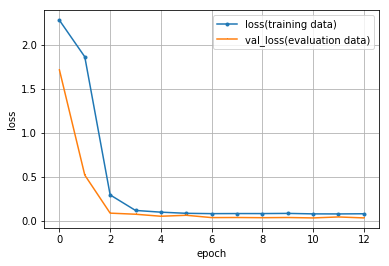

In [80]:
%matplotlib inline
from matplotlib import pyplot as plt
# Learning rersults
loss = regr_fit.history['loss']
val_loss = regr_fit.history['val_loss']
epochs = len(loss)
plt.plot(range(epochs),loss, marker = '.', label = 'loss(training data)')
plt.plot(range(epochs),val_loss, marker = ',', label = 'val_loss(evaluation data)')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [81]:
# Neuron network Results
from sklearn.metrics import mean_squared_error, r2_score

y_test_predict = regr.predict(X_test)

MSE_nn = (mean_squared_error(y_test, y_test_predict))

print('MSE_nn:', MSE_nn)

MSE_nn: 0.06809990537860323


### LinearSVR

In [82]:
# LinearSVR 
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

grid_values = {'epsilon': [0.005, 0.01, 0.1, 1, 10, 100],
              'C': [0.005, 0.01, 0.1, 1, 10, 100]}

clf = LinearSVR(dual=True, fit_intercept=True,intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,random_state=843647, tol=1e-04, verbose=0)

#clf = LinearSVR()
grid_clf = GridSearchCV(clf, cv = 5, param_grid = grid_values)

grid_clf.fit(X_train, y_train)

#y_decision_fn_scores_acc = grid_clf.predict(X_test) 

print('Grid best parameter (max. accuracy): ', grid_clf.best_params_)

bclf = LinearSVR(**grid_clf.best_params_,random_state=843647)
bclf.fit(X_test, y_test) 
y_test_predict = bclf.predict(X_test)

MSE_lnSVR = (mean_squared_error(y_test, y_test_predict))

print('MSE_lnSVR:', MSE_lnSVR)

Grid best parameter (max. accuracy):  {'C': 0.005, 'epsilon': 0.1}
MSE_lnSVR: 0.5511576425174549


In [92]:
# Apply best parameters

ada_clf = AdaBoostRegressor(bclf,learning_rate = 0.1, n_estimators = 50,random_state=1234)
ada_clf.fit(X_train, y_train)

y_predict = ada_clf.predict(X_test)
y_predict_dummy_mean = lm_dummy_mean.predict(X_test)

print("Mean squared error (Ada: lnSVR): {:.2f}".format(mean_squared_error(y_test, y_predict)))
print('MSE (Ada: lnSVR):',np.square(y_predict-y_test).mean())
print("r2_score (Ada: lnSVR): {:.2f}".format(r2_score(y_test, y_predict)))

Mean squared error (Ada: lnSVR): 0.07
MSE (Ada: lnSVR): 0.07155977888922206
r2_score (Ada: lnSVR): 0.93


### SVC with kernel trick

SVC RBF

In [84]:
# SVR RBF
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

grid_values = {'gamma': [0.01, 0.1, 1, 10, 100],
              'C': [0.01, 0.1, 1, 10, 100]}

svr_rbf = SVR(kernel='rbf')

grid_clf = GridSearchCV(svr_rbf, cv = 5, param_grid = grid_values)

grid_clf.fit(X_train, y_train)

print('Grid best parameter (max. accuracy): ', grid_clf.best_params_)

bsvr_rbf = SVR(kernel = 'rbf',**grid_clf.best_params_)
bsvr_rbf.fit(X_test, y_test) 
y_test_predict = bsvr_rbf.predict(X_test)

MSE_rbf = (mean_squared_error(y_test, y_test_predict))

print('MSE_rbf:', MSE_rbf)

Grid best parameter (max. accuracy):  {'C': 10, 'gamma': 0.01}
MSE_rbf: 0.005650774344329945
